# ADA Project : Creative Extension
## Chilling Effects : Online Surveillance and Wikipedia Use

In this notebook, we extend the analysis done in the paper by using an extended time range, and try to answer the following questions:

1. Is there a persistent, long-term chilling effect related to Snowden’s revelation?
2. Can we highlight new chilling effects due to other scandals?
3. What may be the other factors governing the traffic and how are they affecting the article views?

**Content**

[Data Acquisition and processing](#data)
- [Data Acquisition](#webScrape)
- [Data Preprocessing](#dataProcessing)

[Question 1](#q1)
- [Non-model empirical findings](#non_model_based)
- [Model-based empirical findings](#model_based)

[Question 2](#q2)
- [Cambridge Analytica](#cambridge_analytica)
- [Vault 7](#vault_7)

[Question 3](#q3)
- [Growth of Internet](#internetUsers)



In [1]:
#internal imports
import scraping

#external imports
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

In [2]:
DATA_DIRECTORY = 'data/'
TERRORISM_TITLES = 'terrorism_titles.txt'
TERRORISM_DATA = 'terrorism.csv'
SECURITY_TITLES = 'security_titles.txt'
SECURITY_DATA = 'security.csv'
INTERNET_USERS = 'worldInternetUsers.csv'

<a id="data"></a>
## Data Acquisition and processing
<a id="webScrape"></a>
### Web scraping

The first step is to scrape the website [wikipediaviews](https://wikipediaviews.org) in order to get monthly pageviews of the terrorism-related articles for the time range 2008-2018. Note that the data provided by this site is based on both `stats.grok.se` (for the period before June 2015) and the Wikimedia REST API (for the period after).

We will only consider the English Wikipedia and we ignore pageviews from mobile devices.

In [3]:
# We can scrape the data and save it in a CSV file using this function (available in the file scraping.py)
#scraping.scrape_wikipedia_pageviews(2008, 1, 2018, 12, DATA_DIRECTORY, ARTICLES_TITLES, TERRORISM_DATA)
#scraping.scrape_wikipedia_pageviews(2008, 1, 2018, 12, DATA_DIRECTORY, SECURITY_TITLES, SECURITY_DATA)

<a id="dataProcessing"></a>
### Data processing

In [4]:
terrorism = pd.read_csv(DATA_DIRECTORY + TERRORISM_DATA, usecols=[1, 2, 3])
print(terrorism.shape[0], 'lines')
terrorism.sample(4)

6336 lines


,article,date,views
4494,pirates,2008-07,9554.0
2391,farc,2009-04,9754.0
2039,environmental_terrorism,2012-12,NaN
3362,irish_republican_army,2013-03,NaN


In [5]:
security = pd.read_csv(DATA_DIRECTORY + SECURITY_DATA, usecols=[1, 2, 3])
print(security.shape[0], 'lines')
security.sample(4)

3300 lines


,article,date,views
2953,united_nations,2012-02,258180.0
2761,transportation_security_administration,2018-02,34.0
1154,emergency_management,2016-03,13390.0
80,air_marshal,2014-09,NaN


In [6]:
# We handle the NaN values 
terrorism = terrorism[~terrorism.views.isna() & terrorism.views != 0]
terrorism['date'] = pd.to_datetime(terrorism['date'])  # convert date to datetime
print(terrorism.shape[0], 'lines')
terrorism.sample(4)

4105 lines


,article,date,views
5155,suicide_attack,2008-08-01,12971.0
5868,terror,2013-01-01,6091.0
4448,palestine_liberation_front,2015-09-01,1241.0
3207,iraq,2011-04-01,132716.0


In [7]:
# We handle the NaN values 
security = security[~security.views.isna() & security.views != 0]
security['date_str'] = security['date']
security['date'] = pd.to_datetime(security['date'])  # convert date to datetime
print(security.shape[0], 'lines')
security.sample(4)

1496 lines


,article,date,views,date_str
2217,national_guard,2016-10-01,572.0,2016-10
2243,national_guard,2018-12-01,489.0,2018-12
371,border_patrol,2016-12-01,53.0,2016-12
1523,federal_aviation_administration,2013-12-01,13809.0,2013-12


In [8]:
# read the internet users for each month 
internet_users = pd.read_csv(DATA_DIRECTORY + INTERNET_USERS, parse_dates=["Month"])
internet_users.set_index("Month", inplace=True)
internet_users.sample(4)

,Users,Percentage of World Population,Source
Month,,,
2010-09-01,1971000000,28.8,Internet World Stats
2012-09-01,2439000000,34.8,Internet World Stats
2014-06-01,3035000000,42.3,Internet World Stats
2008-03-01,1407000000,21.1,Internet World Stats


### Verifying Data

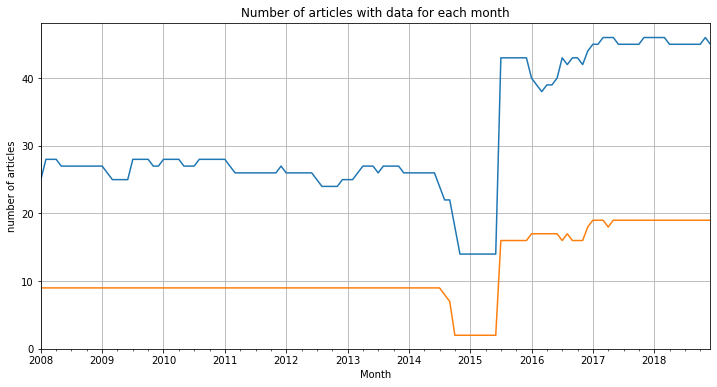

In [9]:
# first we need to compute number of articles per month
terrorism_group_count = terrorism.groupby("date").count() # now this has article count per each month
security_group_count = security.groupby("date").count() # now this has article count per each month
# now let's plot the data
fig, ax = plt.subplots()
terrorism_group_count["article"].plot(ax=ax)
security_group_count["article"].plot(ax=ax)
fig.set_size_inches(12, 6)
ax.set_ylim(bottom=0)
ax.set_title("Number of articles with data for each month")
ax.set_ylabel("number of articles")
ax.set_xlabel("Month")
ax.grid()

We have less number of articles before 2015 and after 2015, we have data for almost all the articles. We will consider this factor in the following questions

In [10]:
terrorism_original = terrorism.copy()
# let's try to remove articles where view counts are not present at least 50% (~65 datapoints) of the time
terrorism_count_df = terrorism.groupby("article").count().views
terrorism_worth_considering = terrorism_count_df[terrorism_count_df>65].index
terrorism_worth_considering # the list of articles that have data for atleast 65 months

Index(['abu_sayyaf', 'afghanistan', 'al-qaeda',
       'al-qaeda_in_the_arabian_peninsula', 'ammonium_nitrate', 'attack',
       'biological_weapon', 'car_bomb', 'chemical_weapon', 'farc', 'hamas',
       'hezbollah', 'iran', 'iraq', 'islamist', 'nationalism', 'nigeria',
       'nuclear', 'pakistan', 'pirates', 'political_radicalism', 'recruitment',
       'somalia', 'suicide_attack', 'taliban', 'terror', 'terrorism', 'yemen'],
      dtype='object', name='article')

In [11]:
security_original = security.copy()
# Same thing for security articles
security_count_df = security.groupby("article").count().views
security_worth_considering = security_count_df[security_count_df>65].index
security_worth_considering

Index(['bureau_of_land_management', 'central_intelligence_agency', 'dea',
       'emergency_management', 'federal_aviation_administration',
       'federal_bureau_of_investigation',
       'federal_emergency_management_agency', 'secure_border_initiative',
       'united_nations'],
      dtype='object', name='article')

In [12]:
# new dataframe with articles in the above list
terrorism = terrorism[terrorism["article"].isin(terrorism_worth_considering)]
security = security[security["article"].isin(security_worth_considering)]

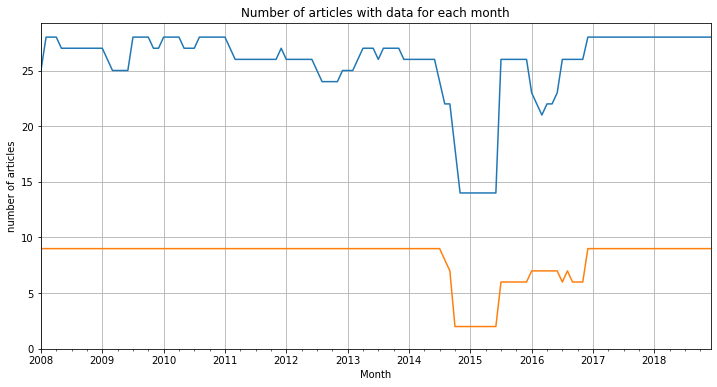

In [13]:
# first we need to compute number of articles per month
terrorism_group_count = terrorism.groupby("date").count() # now this has article count per each month
security_group_count = security.groupby("date").count() # now this has article count per each month
# now let's plot the data
fig, ax = plt.subplots()
terrorism_group_count["article"].plot(ax=ax)
security_group_count["article"].plot(ax=ax)
fig.set_size_inches(12, 6)
ax.set_ylim(bottom=0)
ax.set_title("Number of articles with data for each month")
ax.set_ylabel("number of articles")
ax.set_xlabel("Month")
ax.grid()

Now the plot looks better. However we still have the problem with very less articles in end of 2015 to mid 2016

<a id="q1"></a>
## Question 1 : Is there a persistant chilling effect ? 

First, we sum the pageviews of all the articles for each month.

In [14]:
# Now we sum the article views of the same month
terror_month = terrorism.groupby(["date"]).sum().reset_index()
terror_month["num"] = np.arange(1, len(terror_month)+1)
# Same thing for the security articles that will be used later
security_month = security.groupby(["date"]).sum().reset_index()
security_month["num"] = np.arange(1, len(security_month)+1)

<a id="non_model_based"></a>
## 1.1 Non-model empirical findings
Here, we present findings that do not rely on a statiscal model. We computed the average monthly number of views, before and after the june 2013 events

In [15]:
# we will add a column to the dataframe to indicate before or after the Snowden incident
terror_month["before_June_2013"] = terror_month["date"].apply(lambda x: 'Pre June 2013' if x < pd.to_datetime("2013-06-01") else 'Post June 2013')

Text(0.5, 1.0, 'Average views before and after June-2013 with 95% confidence interval')

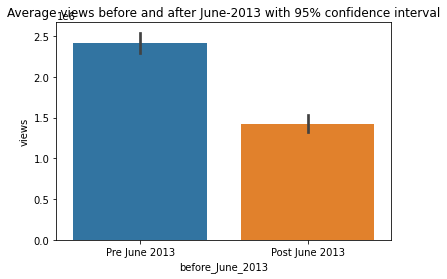

In [16]:
# now let's plot the data
fig, ax = plt.subplots()
ax =sns.barplot(x="before_June_2013", y="views", data=terror_month)
ax.set_title("Average views before and after June-2013 with 95% confidence interval")

We can clearly notice a significant reduction after the revelations, which is also highlighted with 95% confidence interval. A reduction after the June 2013 surveillance revelations may suggest a chilling effect.

In [17]:
# create subsets, pre & post June 2013
data_pre = terror_month[terror_month.before_June_2013 == "Pre June 2013"]
data_post = terror_month[terror_month.before_June_2013 == "Post June 2013"]
avg_month_view = pd.DataFrame({'time':['Pre-june', 'Post-june'], 'avg':[data_pre.views.mean(), data_post.views.mean()]})
avg_month_view

,time,avg
0,Pre-june,2.420856e+06
1,Post-june,1.423716e+06


In [18]:
# average month views change in percent
avg_month_view.avg.pct_change()

0         NaN
1   -0.411896
Name: avg, dtype: float64

In [19]:
# average month views change
avg_month_view.avg.diff()

0              NaN
1   -997140.514351
Name: avg, dtype: float64

The difference in mean values before and after June 2013 is notable : We notice a reduction of **936426.9** in the average monthly views for the articles, which represents approximately a **38.7%** drop in article view counts.

<a id="model_based"></a>
## 1.2 Model-based empirical findings

We then performed an *Interrupted Time Series* (ITS) analysis, by fitting a linear regressor before and after our "iterruption" (here, the June 2013 revelations).

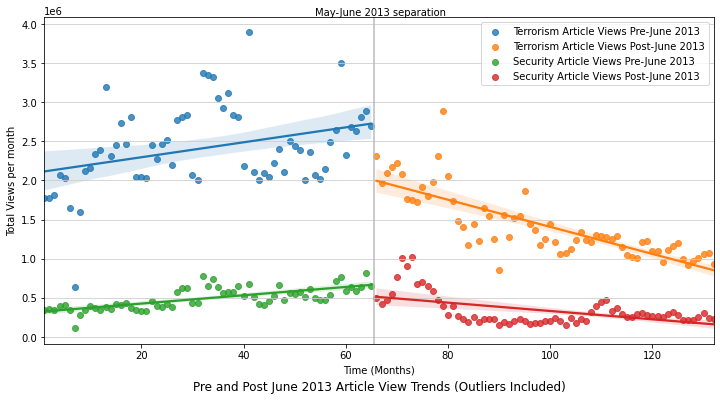

In [20]:
# now let's plot this result
fig, ax = plt.subplots(figsize=(12,6))
sns.regplot(x="num", y="views", ax=ax, data=data_pre, label="Terrorism Article Views Pre-June 2013")
sns.regplot(x="num", y="views", ax=ax, data=data_post, label="Terrorism Article Views Post-June 2013")
# Add the security-related articles as a comparison
sns.regplot(x="num", y="views", ax=ax, data=security_month[:65], label="Security Article Views Pre-June 2013")
sns.regplot(x="num", y="views", ax=ax, data=security_month[65:], label="Security Article Views Post-June 2013")

# line and marker between May and June 2013
ax.axvline(x=65.5, color="#bbbbbb") 
_, top = ax.get_ylim()
plt.text(54,top+3e4,'May-June 2013 separation')

# plot axes, legends and etc...
ax.set_title("Pre and Post June 2013 Article View Trends (Outliers Included)", y=-0.16)
ax.legend(loc='best')
ax.set_xlabel("Time (Months)")
ax.set_ylabel("Total Views per month")
ax.grid(axis='y',color='#cccccc')

The sudden drop in views and trend shift from increasing monthly views over time to decreasing after June 2013 is consistent with a significant and long-term chilling effect. We also notice that we did not need to remove outliers to obtain results that are consistent with the chilling effect hypothesis. One can discuss if we also need to perform a ITS without the outliers.
 
If we look at the security articles, the drop-off is not significant. However, there still seems to be a slight change in the slope. Instead of steadily growing, the data shows a sudden peak followed by lower values than in the first segment. It means that part of the slope variation for the terrorism articles may be explained by other factors, but the result is still significant enought to indicate a chilling effect.

## 1.3 Comparison with the unprocessed dataframe

In the data processing step we removed some data in order to have a uniform number of articles for each month. Does it have an influence ? We will redo the analysis with the unprocessed dataframe.

Text(0.5, 1.0, 'Average views before and after June-2013 with 95% confidence interval')

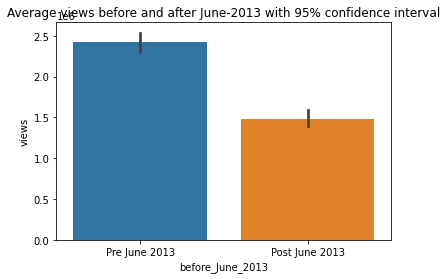

In [21]:
# Now we sum the article views of the same month
terror_month_original = terrorism_original.groupby(["date"]).sum().reset_index()
terror_month_original["num"] = np.arange(1, len(terror_month_original)+1)
# Same thing for the security articles that will be used later
security_month_original = security_original.groupby(["date"]).sum().reset_index()
security_month_original["num"] = np.arange(1, len(security_month_original)+1)
# we will add a column to the dataframe to indicate before or after the Snowden incident
terror_month_original["before_June_2013"] = terror_month_original["date"].apply(lambda x: 'Pre June 2013' if x < pd.to_datetime("2013-06-01") else 'Post June 2013')
# now let's plot the data
fig, ax = plt.subplots()
ax = sns.barplot(x="before_June_2013", y="views", data=terror_month_original)
ax.set_title("Average views before and after June-2013 with 95% confidence interval")

In [22]:
# create subsets, pre & post June 2013
data_pre_original = terror_month_original[terror_month_original.before_June_2013 == "Pre June 2013"]
data_post_original = terror_month_original[terror_month_original.before_June_2013 == "Post June 2013"]
avg_month_view_original = pd.DataFrame({'time':['Pre-june', 'Post-june'], 'avg':[data_pre_original.views.mean(), data_post_original.views.mean()]})
# average month views change in percent
print("change in percent")
print(avg_month_view_original.avg.pct_change())

# average month views change
print("Change of number of views")
print(avg_month_view_original.avg.diff())

change in percent
0         NaN
1   -0.386816
Name: avg, dtype: float64
Change of number of views
0              NaN
1   -936426.947187
Name: avg, dtype: float64


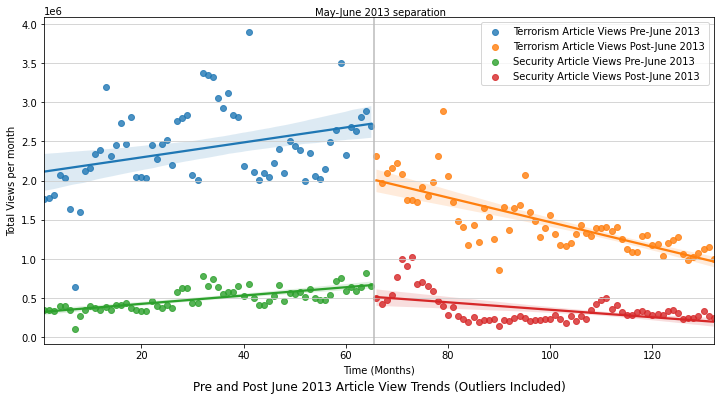

In [23]:
# now let's plot this result
fig, ax = plt.subplots(figsize=(12,6))
sns.regplot(x="num", y="views", ax=ax, data=data_pre_original, label="Terrorism Article Views Pre-June 2013")
sns.regplot(x="num", y="views", ax=ax, data=data_post_original, label="Terrorism Article Views Post-June 2013")
# Add the security-related articles as a comparison
sns.regplot(x="num", y="views", ax=ax, data=security_month_original[:65], label="Security Article Views Pre-June 2013")
sns.regplot(x="num", y="views", ax=ax, data=security_month_original[65:], label="Security Article Views Post-June 2013")

# line and marker between May and June 2013
ax.axvline(x=65.5, color="#bbbbbb") 
_, top = ax.get_ylim()
plt.text(54,top+3e4,'May-June 2013 separation')

# plot axes, legends and etc...
ax.set_title("Pre and Post June 2013 Article View Trends (Outliers Included)", y=-0.16)
ax.legend(loc='best')
ax.set_xlabel("Time (Months)")
ax.set_ylabel("Total Views per month")
ax.grid(axis='y',color='#cccccc')

The results are almost identical. But in the following analysis we will continue with the processed dataframe.

<a id="q2"></a>
## Question 2 : other scandals ?

<a id="cambridge_analytica"></a>
### Cambridge Analytica

The [Cambridge Analytica scandal](https://en.wikipedia.org/wiki/Facebook%E2%80%93Cambridge_Analytica_data_scandal) was mostly revealed in March 2018 and it exposed the mass data collections of millions of Facebook users. This data was used to make targeted advertisement campaigns for the 2016 US elections, by creating psychological profiles of voters.

Since it is related to Facebook profiles, this incident does not have a direct link with government surveillance and terrorism. Thus, it would be surprising to observe a direct chilling effect in our dataset. However, this type of incident may be able to revive and accentuate privacy concerns in the population. This could either decrease the feeling of security and anonymity online, or serve as a reminder of the Snowden scandal.

In the following plot we will see if there is a significant drop in pageviews at this particular date, which would support our hypotheses and potentially indicate another chilling effect.

In [24]:
# March 17, 2018
march_2018 = terror_month.loc[terror_month['date'] == pd.to_datetime('2018-03-01'), 'num'].iloc[0]

# Focus on the two year before and the 10 months after the revelations
data_pre = terror_month.loc[terror_month['num'].isin(range(march_2018-24, march_2018)), :]
data_post = terror_month.loc[terror_month['num'].isin(range(march_2018, march_2018+10)), :]

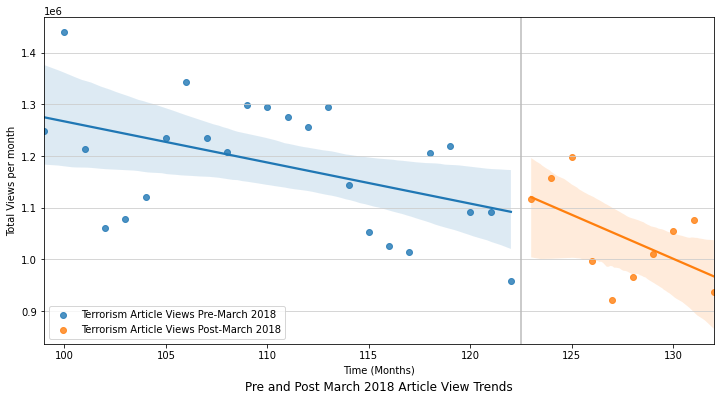

In [25]:
# Plot the results
fig, ax = plt.subplots(figsize=(12,6))
sns.regplot(x="num", y="views", ax=ax, data=data_pre, label="Terrorism Article Views Pre-March 2018")
sns.regplot(x="num", y="views", ax=ax, data=data_post, label="Terrorism Article Views Post-March 2018")

# line and marker between February and March 2018
ax.axvline(x=march_2018-0.5, color="#bbbbbb")

# plot axes, legends and etc...
ax.set_title("Pre and Post March 2018 Article View Trends", y=-0.16)
ax.legend(loc='best')
ax.set_xlabel("Time (Months)")
ax.set_ylabel("Total Views per month")
ax.grid(axis='y',color='#cccccc')

As opposed to June 2013, it seems that there is no significant effect on the pageviews of terrorism-related articles for this date. Thus, we cannot make any claim on the existence of a chilling effect for this incident.

<a id="vault_7"></a>
### Vault 7

The leak of the documents [Vault 7](https://en.wikipedia.org/wiki/Vault_7) was first announced in February 2017 and the documents were released during the following months. It sheds light on an impressive amount of cyber weapons developped or detained by the CIA, that can be used for targeted or mass surveillance. 

The nature of this incident makes it quite similar to the Snowden incident, and thus a more obvious candidate for our search of chilling effects, but the effect may be diminished since the documents were released in 24 parts (until September 2017) and not in a single batch. However, most news coverage was done in March 2017, so we decided to keep this date as the breaking point.

In [26]:
# March 2017
march_2017 = terror_month.loc[terror_month['date'] == pd.to_datetime('2017-03-01'), 'num'].iloc[0]

# Focus on the two years before and after the beginning of the revelations
data_pre = terror_month.loc[terror_month['num'].isin(range(march_2017-24, march_2017)), :]
data_post = terror_month.loc[terror_month['num'].isin(range(march_2017, march_2017+22)), :]

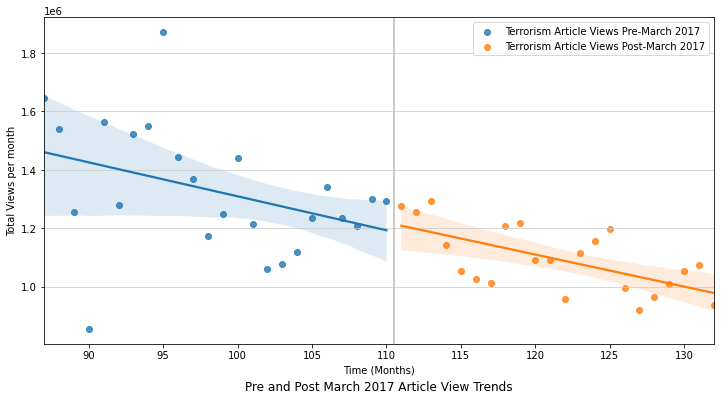

In [27]:
# Plot the results
fig, ax = plt.subplots(figsize=(12,6))
sns.regplot(x="num", y="views", ax=ax, data=data_pre, label="Terrorism Article Views Pre-March 2017")
sns.regplot(x="num", y="views", ax=ax, data=data_post, label="Terrorism Article Views Post-March 2017")

# line and marker between February and March 2017
ax.axvline(x=march_2017-0.5, color="#bbbbbb")

# plot axes, legends and etc...
ax.set_title("Pre and Post March 2017 Article View Trends", y=-0.16)
ax.legend(loc='best')
ax.set_xlabel("Time (Months)")
ax.set_ylabel("Total Views per month")
ax.grid(axis='y',color='#cccccc')

Again, we do not observe any abrupt variation in the number of pageviews around this date.

<a id="q3"></a>
## Question 3 : other factors governing the traffic
<a id="internetUsers"></a>
### Growth of Internet Users

One of the main factors that can affect the Wikipedia traffic will be the number of users. So let's first consider it

<AxesSubplot:xlabel='Month'>

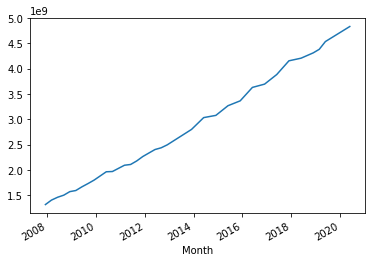

In [28]:
fig, ax = plt.subplots()
internet_users['Users'].plot(ax=ax)

Here we can see an almost linear relationship. We can do a small statistical test to confirm it.

In [29]:
# First we will add a new columns with number of months from 2008 Jan.
internet_users['nb_months'] = (internet_users.index- pd.to_datetime('2007-12-01') )/np.timedelta64(1, 'M')
internet_users['nb_months'] = internet_users['nb_months'].round() # to round the month count
internet_users.head(4)

,Users,Percentage of World Population,Source,nb_months
Month,,,,
2007-12-01,1319000000,20.0,Internet World Stats,0.0
2008-03-01,1407000000,21.1,Internet World Stats,3.0
2008-06-01,1463000000,21.9,Internet World Stats,6.0
2008-09-01,1504000000,22.5,Internet World Stats,9.0


In [30]:
# now we can do the regression
mod = smf.ols(formula='Users ~ nb_months', data=internet_users)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  Users   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     5962.
Date:                Fri, 18 Dec 2020   Prob (F-statistic):           5.21e-37
Time:                        17:31:14   Log-Likelihood:                -645.47
No. Observations:                  33   AIC:                             1295.
Df Residuals:                      31   BIC:                             1298.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.222e+09   2.36e+07     51.778      0.0

As predicted the two variables are highly corelated ($R^2$ value is 0.995) and also we can neglect the null hypothesis because the p value is zero.

And a **fun fact** is according to this, we can safely say internet users grows ~2.3 million each month!

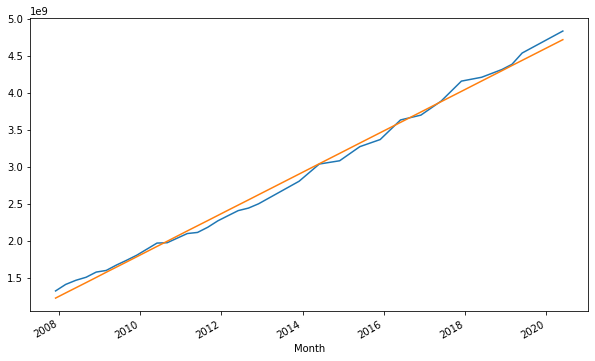

In [31]:
# now let's plot the linear regression line with the previous plot
bias, tangent = res.params
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
internet_users['Users'].plot(ax=ax)
ax.plot(internet_users.index, (internet_users['nb_months']*tangent+bias))

As we can see, we can see a very good match between the actual graph and the regression line. This is a very convinient result as now we can use the regression line for the analysis, thus eliminating the issue of some missing figures in the actual dataset.

In [32]:
# data_pre["internet_users"] = data_pre["num"]*tangent+bias
# data_post["internet_users"] = data_post["num"]*tangent+bias
terror_month["internet_users"] = terror_month["num"]*tangent+bias
terror_month["views_per_million_users"] = terror_month["views"]/terror_month["internet_users"]*1e6
terror_month.head(4)

,date,views,num,before_June_2013,internet_users,views_per_million_users
0,2008-01-01,1770122.0,1,Pre June 2013,1.245405e+09,1421.322076
1,2008-02-01,1779044.0,2,Pre June 2013,1.268699e+09,1402.258026
2,2008-03-01,1810909.0,3,Pre June 2013,1.291994e+09,1401.639239
3,2008-04-01,2074790.0,4,Pre June 2013,1.315288e+09,1577.441781


In [33]:
# As a comparison, we do the same for the security articles
security_month["internet_users"] = security_month["num"]*tangent+bias
security_month["views_per_million_users"] = security_month["views"]/security_month["internet_users"]*1e6

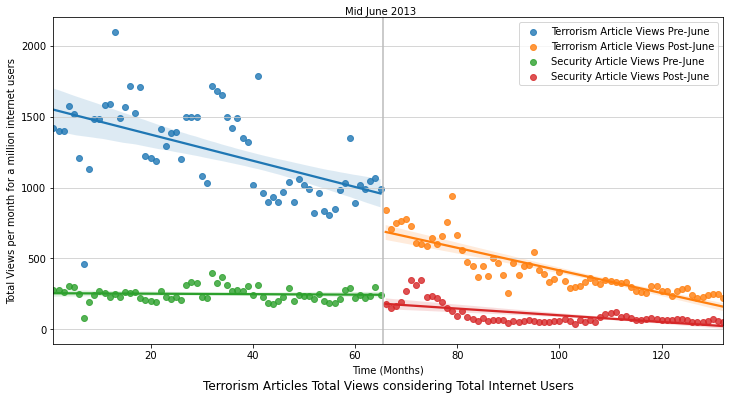

In [34]:
# now let's plot this result
fig, ax = plt.subplots(figsize=(12,6))
sns.regplot(x="num", y="views_per_million_users", ax=ax, data=terror_month[:65], label="Terrorism Article Views Pre-June")
sns.regplot(x="num", y="views_per_million_users", ax=ax, data=terror_month[65:], label="Terrorism Article Views Post-June")
sns.regplot(x="num", y="views_per_million_users", ax=ax, data=security_month[:65], label="Security Article Views Pre-June")
sns.regplot(x="num", y="views_per_million_users", ax=ax, data=security_month[65:], label="Security Article Views Post-June")

# line and marker at mid June 2013
ax.axvline(x=65.5, color="#bbbbbb") 
_, top = ax.get_ylim()
plt.text(58,top+20,'Mid June 2013')

# plot axes, legends and etc...
ax.set_title("Terrorism Articles Total Views considering Total Internet Users", y=-0.16)
ax.legend(loc='best')
ax.set_xlabel("Time (Months)")
ax.set_ylabel("Total Views per month for a million internet users")
ax.grid(axis='y',color='#cccccc')

This tells a different story than the conclusion we made above. Now the division between the two categories are not so significant. In other words, when we take the number of internet users in the world, the total traffic for these terrorism related articles have a negative trend.

Interestingly, the security articles seem to be less impacted by the growing number of Internet users.